In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
from muon import prot as pt
from scipy.sparse import issparse
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mofax as mofa
import scib

In [3]:
import psutil
import os
import subprocess
import time
import csv
from datetime import datetime
from threading import Thread

def get_gpu_usage():
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=utilization.gpu,memory.used,memory.total", "--format=csv,noheader,nounits"],
            encoding="utf-8"
        ).strip()
        gpu_usage, mem_used, mem_total = map(int, gpu_info.split(", "))
        return gpu_usage, mem_used, mem_total
    except subprocess.CalledProcessError:
        return None, None, None

def get_system_metrics():
    metrics = {}
    metrics['cpu_usage'] = psutil.cpu_percent(interval=1)
    metrics['cpu_memory_usage'] = psutil.virtual_memory().percent
    metrics['overall_memory_usage'] = psutil.virtual_memory().used / (1024 ** 3)  # in GB

    gpu_usage, gpu_mem_used, gpu_mem_total = get_gpu_usage()
    metrics['gpu_usage'] = gpu_usage
    metrics['gpu_memory_used'] = gpu_mem_used
    metrics['gpu_memory_total'] = gpu_mem_total
    return metrics

In [4]:
#Data Loading and PreProcessing ( for BMMC DATA ) 
adata = sc.read("./data/BMMC_processed.h5ad")

adata = sc.read('./data/BMMC_processed.h5ad')
# subset to first 3 donors with B, Mono and T cell subtypes
adata = adata[adata.obs.DonorID.isin([10886, 11466, 12710]) & adata.obs.cell_type.isin(np.unique(adata.obs.cell_type.values)[:17])]
adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype('category')
adata.var["gene_name"] = adata.var.index.tolist()
adata.obs["str_batch"] = adata.obs["batch"].astype('category')
adata_protein = adata[:, adata.var.feature_types.isin(['ADT'])].copy()
adata_protein.var.index = ['p_' + i for i in adata_protein.var.index]
adata_rna = adata[:, adata.var.feature_types.isin(['GEX'])].copy()
data_is_raw = False

prot = adata_protein
prot

mdata = mu.MuData({'rna': adata_rna, 'protein': adata_protein})


# Collecting metrics(custom script in chunk2)
chunk_name = "Data_Loading_PreProcessing"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics_MOFA_test.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/anndata/_io/specs/registry.py:275: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/anndata/_io/utils.py:211: OldFormatWarning: Element '/obs/GEX_n_genes_by_counts' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/anndata/_io/utils.py:211: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/anndata/_io/utils.py:211: OldFormatWarning: Element '/obs/GEX_size_factors' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/anndata/_io/utils.py:211: OldFormatWarning: E

Metrics for Data_Loading_PreProcessing collected and logged successfully.


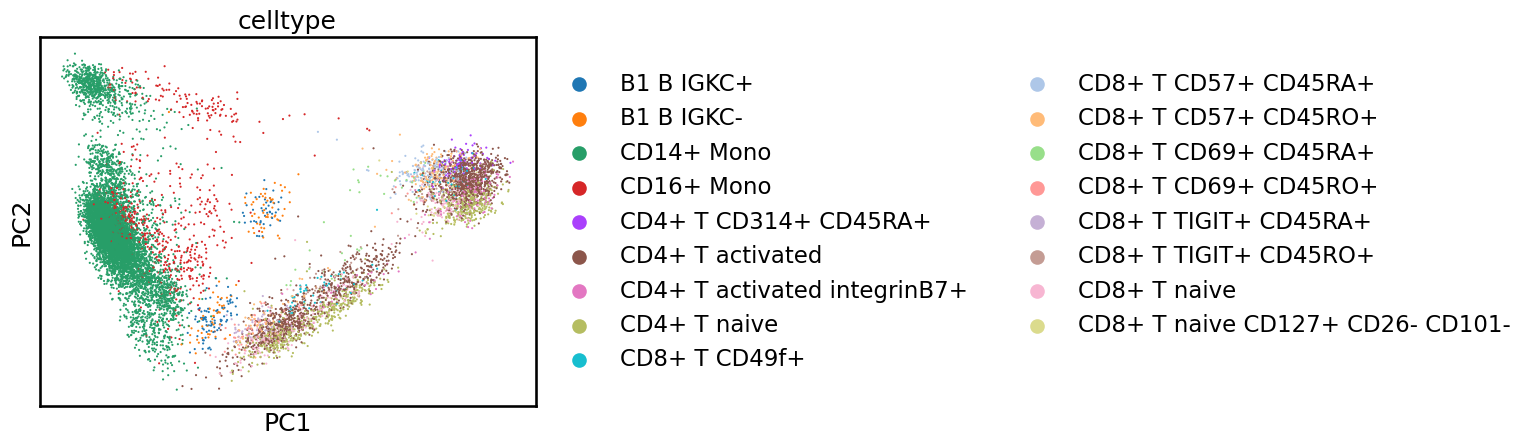

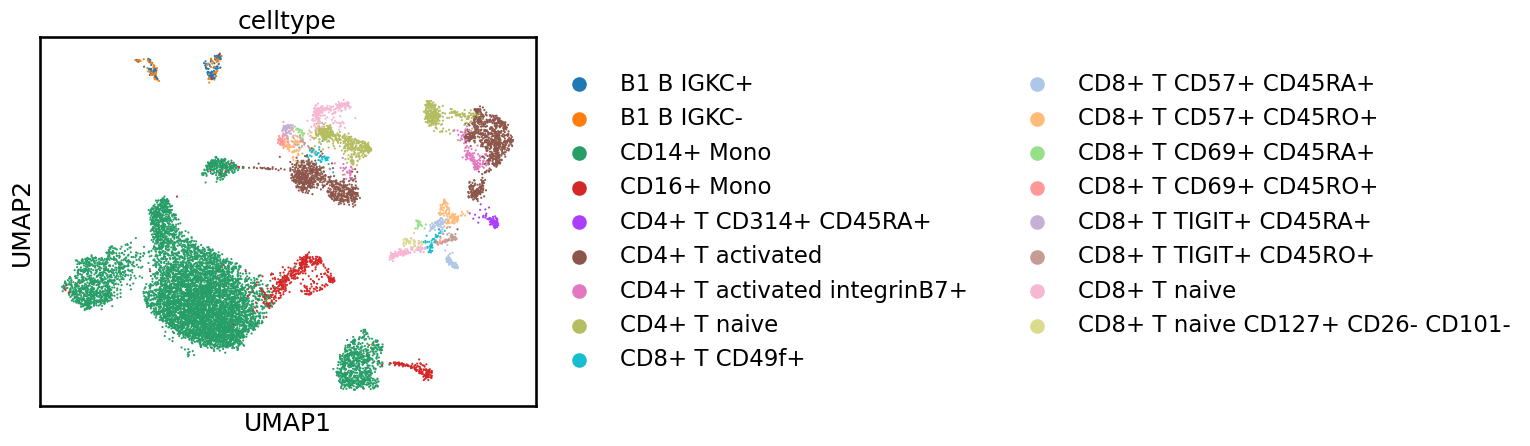

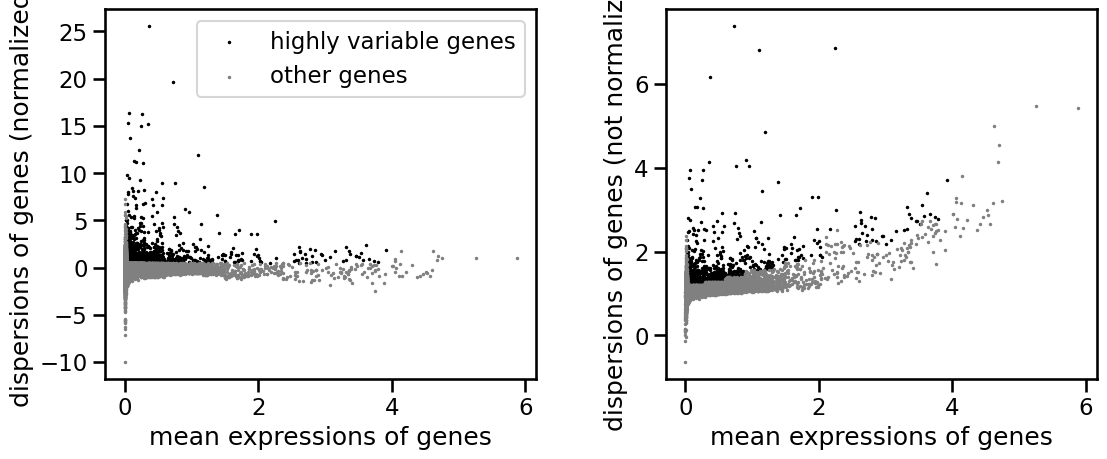

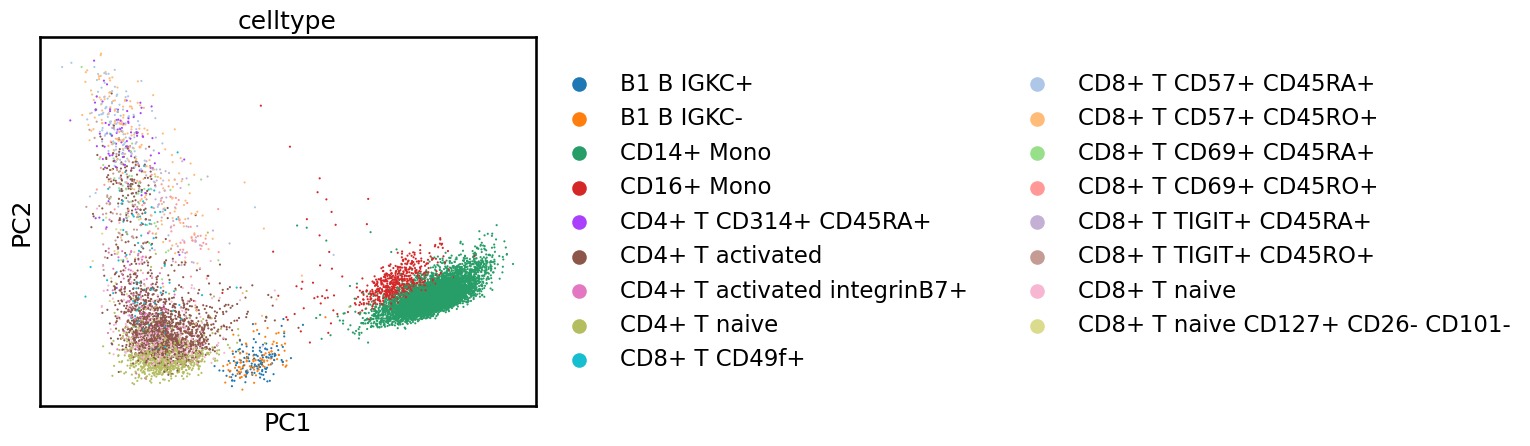

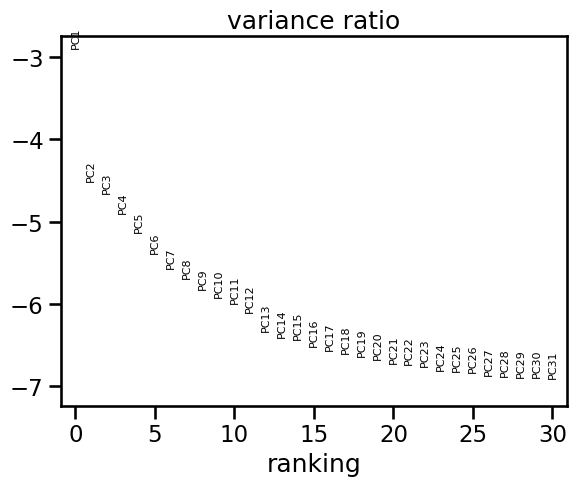

/tmp/ipykernel_218641/2477811742.py:36: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna, resolution=.75)


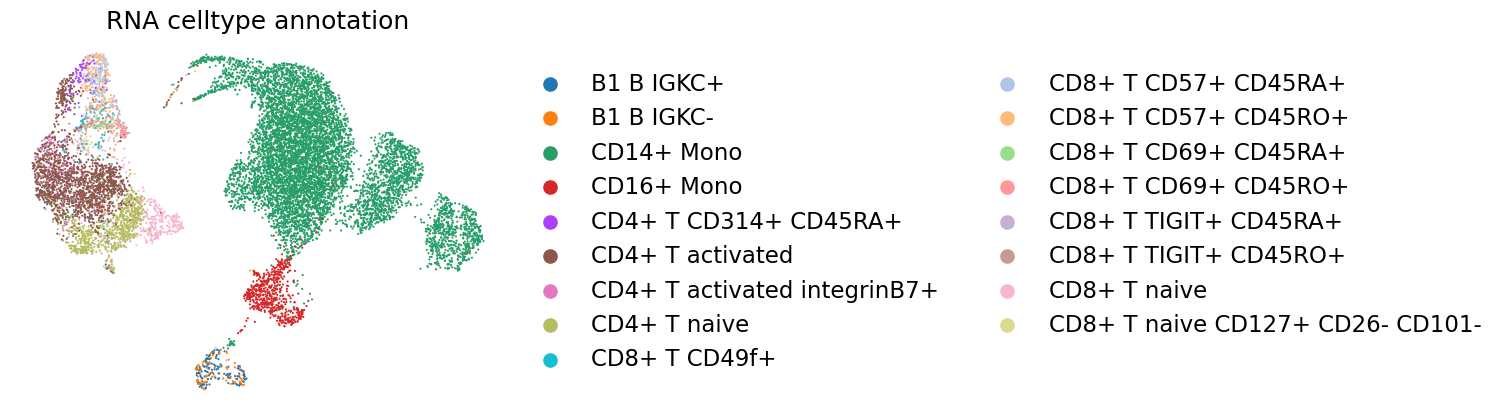

Metrics for Clustering_Dimensionality collected and logged successfully.


In [5]:
#PCA And UMAP (Clustering and Dimensionality)
sc.tl.pca(prot)

sc.pl.pca(prot, color = "celltype")

sc.pp.neighbors(prot)

sc.tl.umap(prot, random_state=1)
sc.pl.umap(prot, color = "celltype")

rna = adata_rna
rna

sc.pp.normalize_total(rna, target_sum=1e4)      #Uncomment for FLU DATA

sc.pp.log1p(rna)

sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

sc.pl.highly_variable_genes(rna)

np.sum(rna.var.highly_variable)

rna.raw = rna

sc.pp.scale(rna, max_value=10)

sc.tl.pca(rna, svd_solver='arpack')

sc.pl.pca(rna,color = "celltype")

sc.pl.pca_variance_ratio(rna, log=True)

sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

sc.tl.leiden(rna, resolution=.75)

sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

sc.pl.umap(rna, color="celltype", frameon=False,
          title="RNA celltype annotation")


# Collecting metrics(custom script in chunk2)
chunk_name = "Clustering_Dimensionality"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics_MOFA_test.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

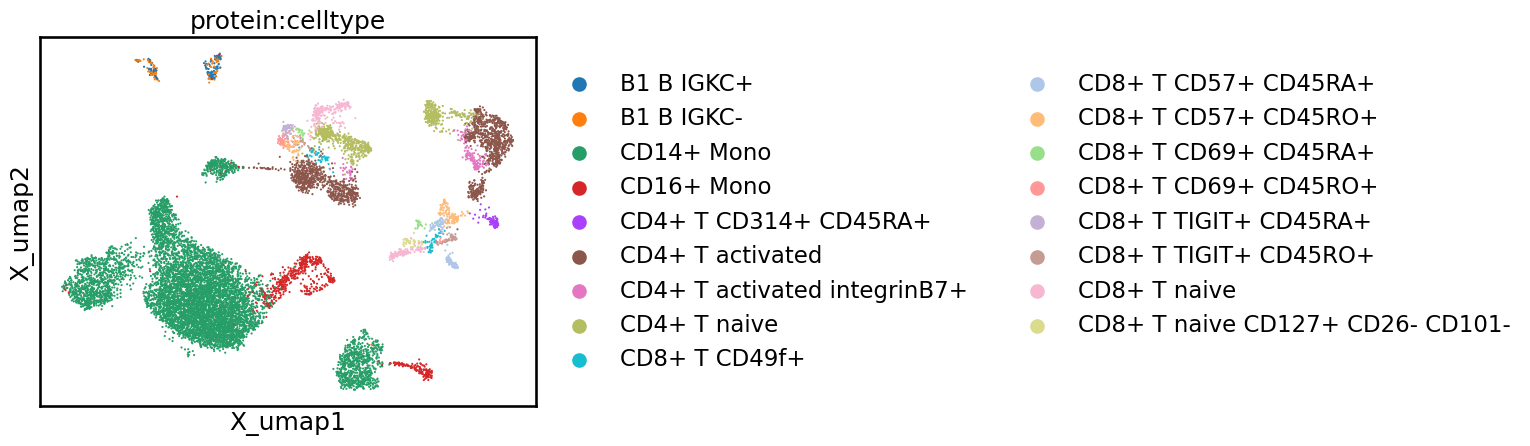

/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


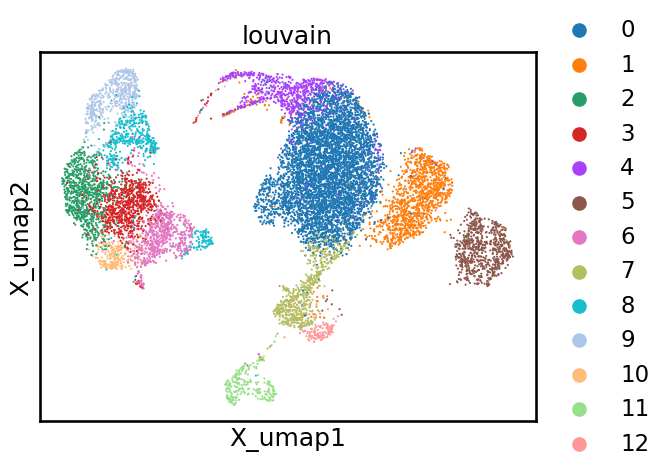


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/ssh-user/miniconda/envs/scGPT_2/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Loaded view='rna' group='group1' with N=12578 samples and D=1794 features...
Loaded view='protein' group='group1' with N=12578 samples and D=134 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (rna): gaussian
- View 1 (protein): gaussian




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in models/BMMC_v2.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


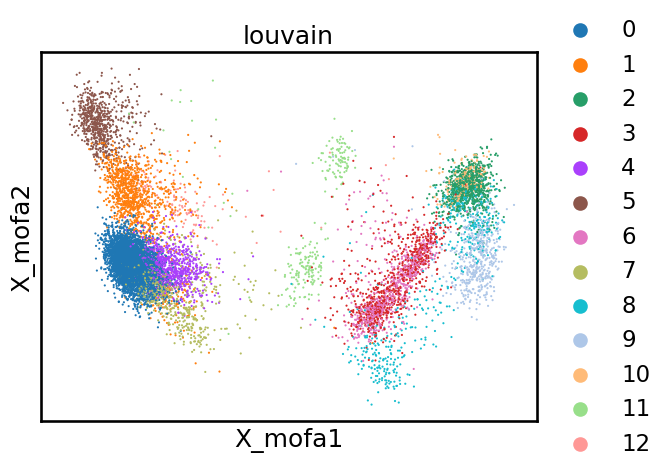

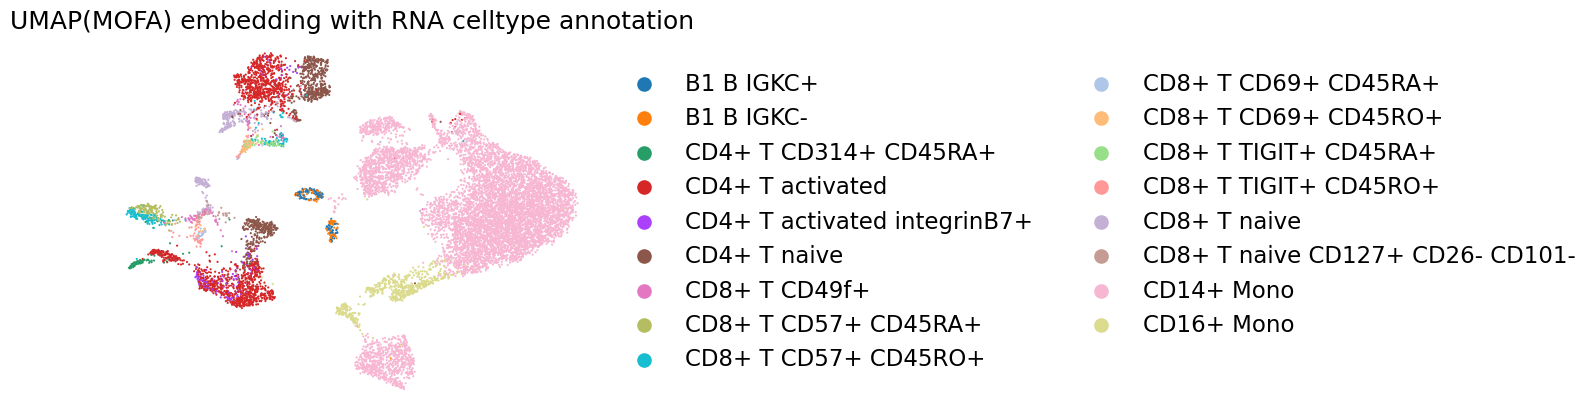

Metrics for MOFA_RUN collected and logged successfully.


In [6]:
#MOFA RUN 
mu.pl.embedding(mdata, basis="protein:X_umap", color="protein:celltype")

mu.pp.intersect_obs(mdata)

mu.tl.louvain(mdata, resolution=[2, .1], random_state=1)

mu.pl.embedding(mdata, basis="rna:X_umap", color="louvain")

prot.var["highly_variable"] = True
mdata.update()

mu.tl.mofa(mdata, outfile="models/BMMC_v2.hdf5",
           n_factors=30)

mu.pl.mofa(mdata, color='louvain')

sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

mu.pl.umap(mdata, color=['rna:celltype'], frameon=False,
           title="UMAP(MOFA) embedding with RNA celltype annotation")


# Collecting metrics(custom script in chunk2)
chunk_name = "MOFA_RUN"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics_MOFA_test.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

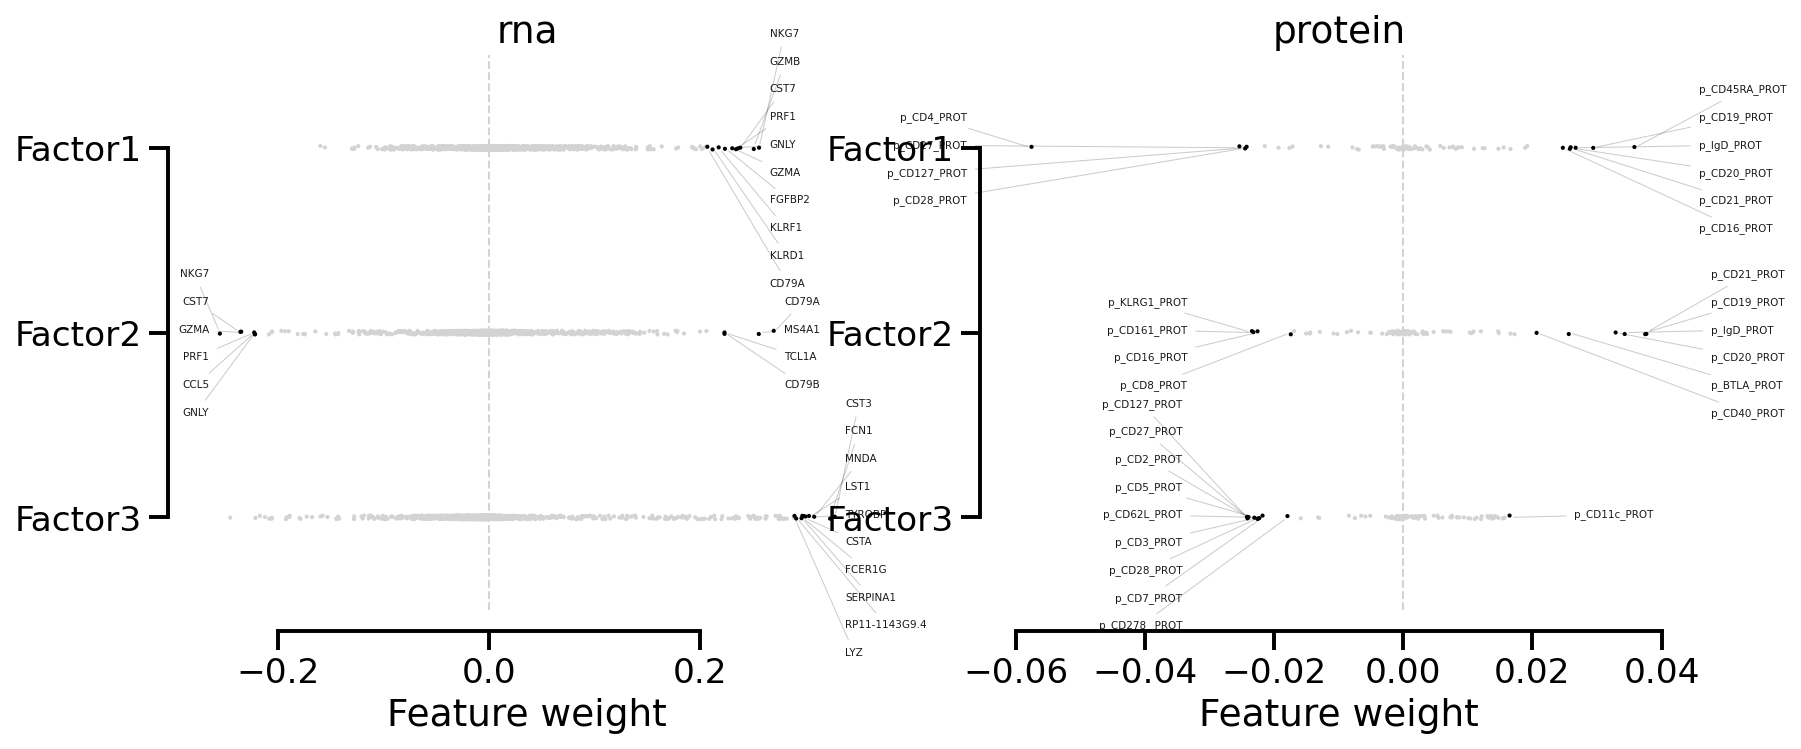

In [7]:
rcParams['figure.dpi'] = 150
model = mofa.mofa_model("models/H1N1_citeseq_v2.hdf5")
mofa.plot_weights(model, factors=range(3), n_features=10, sharex=False)

mdata
mdata.obsm["X_mofa_umap"] = mdata.obsm["X_umap"]

WNN INTEGRATION

In [7]:
# # Since subsetting was performed after calculating nearest neighbours,
# # we have to calculate them again for each modality.
# sc.pp.neighbors(mdata.mod['rna'])
# sc.pp.neighbors(mdata.mod['protein'])


# # Calculate weighted nearest neighbors
# mu.pp.neighbors(mdata, key_added='wnn')

# mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)

# print(mdata.obs.columns)

# #Compare modalities weights
# mu.pl.umap(mdata, color=['rna:mod_weight', 'protein:mod_weight'], cmap='RdBu')

# #Calculate neighbors and generate umaps
# sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
# sc.pl.umap(mdata, color='leiden_wnn', legend_loc='on data')

# sc.pl.violin(mdata, groupby='leiden_wnn', keys='protein:mod_weight')

# mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
# mdata.mod['rna'].obsm['X_wnn_umap'] = mdata.obsm['X_wnn_umap']

In [8]:
# #MOFA and WNN Umap Comparison
# mu.pl.embedding(mdata, basis="X_mofa_umap", frameon=False, title="MOFA\u2192UMAP", color="leiden_mapped")
# mu.pl.embedding(mdata, basis="X_wnn_umap", frameon=False, title="WNN\u2192UMAP", color="leiden_wnn")

In [9]:
# # Assuming 'rna' is your AnnData object
# sc.tl.leiden(rna, resolution=0.75, flavor='igraph', n_iterations=2, directed=False)

TCTTGCGGTCATTGCA-1-s1d2           CD4+ T CD314+ CD45RA+
CGGGCATCACGTCATA-1-s1d2    CD4+ T activated integrinB7+
GGGTTTATCTCTATGT-1-s1d2                      CD14+ Mono
TACCGGGGTGACTATC-1-s1d2                    CD4+ T naive
ACGATCAGTACGAGTG-1-s1d2                CD4+ T activated
                                       ...             
CAACGGCTCACTGATG-1-s3d7                      CD14+ Mono
GTGTAACCATTAAGCC-1-s3d7                      CD14+ Mono
CAGCCAGCAACGCATT-1-s3d7                      CD14+ Mono
ATCACAGTCGCCAACG-1-s3d7                      CD14+ Mono
TTATTGCAGGTAGCCA-1-s3d7                      CD14+ Mono
Name: celltype, Length: 12578, dtype: category
Categories (17, object): ['B1 B IGKC+', 'B1 B IGKC-', 'CD14+ Mono', 'CD16+ Mono', ..., 'CD8+ T TIGIT+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T naive', 'CD8+ T naive CD127+ CD26- CD101-']

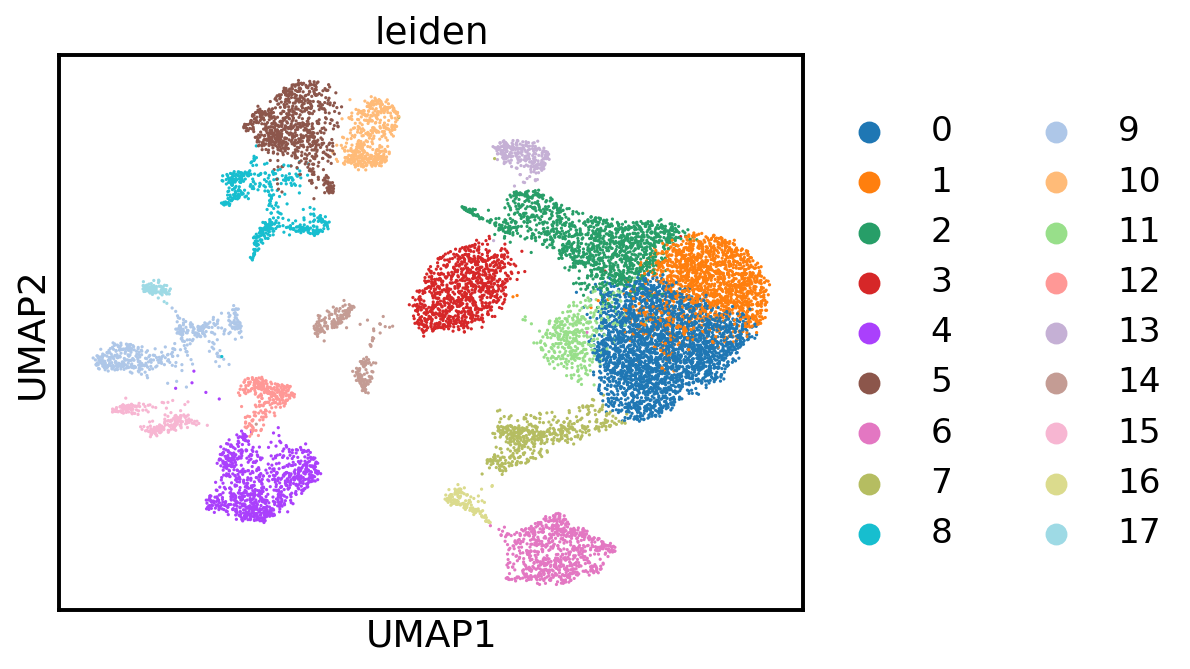

{'15': 'CD4+ T activated', '4': 'CD4+ T activated', '6': 'CD14+ Mono', '12': 'CD4+ T naive', '16': 'CD16+ Mono', '9': 'CD8+ T CD69+ CD45RA+', '17': 'CD8+ T naive', '14': 'B1 B IGKC-', '0': 'CD14+ Mono', '2': 'CD14+ Mono', '7': 'CD16+ Mono', '8': 'CD8+ T CD69+ CD45RO+', '3': 'CD14+ Mono', '5': 'CD4+ T activated', '10': 'CD4+ T activated', '13': 'CD14+ Mono', '1': 'CD14+ Mono', '11': 'CD14+ Mono'}
Leiden to Cell Type Mapping: {'0': 'CD14+ Mono', '1': 'CD14+ Mono', '2': 'CD14+ Mono', '3': 'CD14+ Mono', '4': 'CD4+ T activated', '5': 'CD4+ T activated', '6': 'CD14+ Mono', '7': 'CD16+ Mono', '8': 'CD8+ T naive', '9': 'CD8+ T CD57+ CD45RA+', '10': 'CD4+ T naive', '11': 'CD14+ Mono', '12': 'CD4+ T naive', '13': 'CD14+ Mono', '14': 'B1 B IGKC+', '15': 'CD4+ T activated', '16': 'CD16+ Mono', '17': 'CD8+ T naive'}


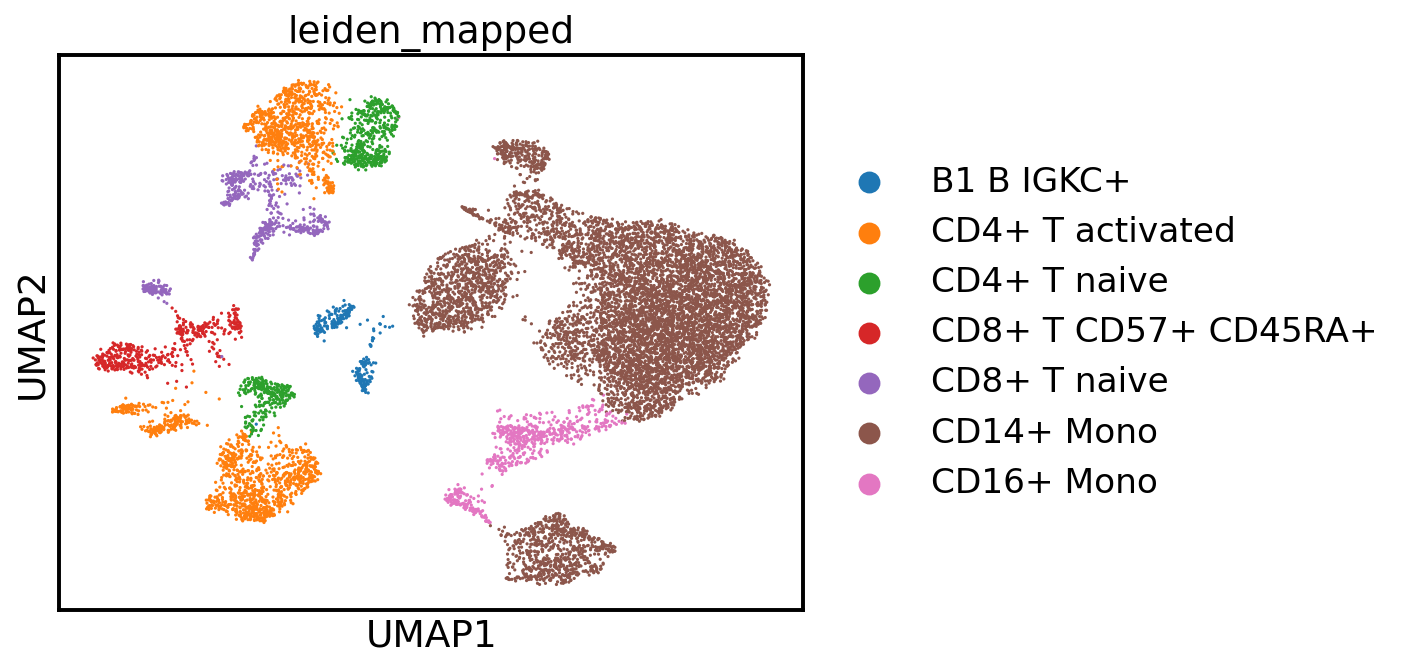

NMI: 0.8248875447690244
ARI: 0.9547505616032999
Silhouette Score: 0.5715793967247009
avg_bio: 0.7837391676990083
Metrics for Metric_Evaluation collected and logged successfully.


In [11]:
#preprocessing for Metric Collection
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test_overestim_var')
display(rna.obs['celltype'])
rna.obs.celltype = rna.obs.celltype.astype("category")

sc.pp.neighbors(mdata, use_rep='X_mofa')
sc.tl.leiden(mdata, resolution=0.5)
sc.tl.umap(mdata)
sc.pl.umap(mdata, color=['leiden'])

#save labels as data frames and get mappings
celltype = pd.DataFrame(mdata.mod['rna'].obs['celltype'])
leiden = pd.DataFrame(mdata.obs['leiden'])
merged_df = pd.merge(celltype, leiden, left_index=True, right_index=True)

mapping = merged_df[['leiden','celltype']].set_index('leiden').to_dict()['celltype']
print(mapping)
leiden_annotations = merged_df.groupby('leiden')['celltype'].agg(lambda x: x.value_counts().idxmax())
leiden_to_celltype = leiden_annotations.to_dict()
print("Leiden to Cell Type Mapping:", leiden_to_celltype)

#Assign mappings 
mdata.obs['leiden_mapped'] = mdata.obs['leiden'].map(leiden_to_celltype)
mdata.obs['leiden_mapped'].nunique()
sc.pl.umap(mdata, color='leiden_mapped')
mdata.mod['rna'].obs['leiden_mapped'] = mdata.obs['leiden_mapped']
mdata.mod['rna'].obsm['X_mofa_umap'] = mdata.obsm['X_mofa_umap']

#MOFA Evaluation Metrics
nmi = scib.metrics.nmi(mdata.mod['rna'], 'celltype', 'leiden_mapped')
ari = scib.metrics.ari(rna, 'celltype', 'leiden_mapped')
silhouette = scib.metrics.silhouette(rna, 'leiden_mapped', embed='X_mofa_umap')

print(f"NMI: {nmi}")
print(f"ARI: {ari}")
print(f"Silhouette Score: {silhouette}")
print(f"avg_bio: {(nmi + ari + silhouette) / 3}")

# Collecting metrics(custom script in chunk2)
chunk_name = "Metric_Evaluation"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics_MOFA_test.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

In [ ]:
# leiden_wnn = pd.DataFrame(mdata.obs['leiden_wnn'])
# merged_df = pd.merge(celltype, leiden, left_index=True, right_index=True)

# mapping = merged_df[['leiden','celltype_m_joint']].set_index('leiden').to_dict()['celltype_m_joint']
# print(mapping)
# leiden_wnn_annotations = merged_df.groupby('leiden')['celltype_m_joint'].agg(lambda x: x.value_counts().idxmax())
# leiden_wnn_to_celltype = leiden_wnn_annotations.to_dict()
# print("Leiden to Cell Type Mapping:", leiden_wnn_to_celltype)

# #Assign mappings 
# mdata.obs['leiden_mapped_wnn'] = mdata.obs['leiden_wnn'].map(leiden_to_celltype)
# mdata.obs['leiden_mapped_wnn'].nunique()
# mdata.mod['rna'].obsm['leiden_mapped_wnn'] = mdata.obs['leiden_mapped_wnn']
# sc.pl.umap(mdata, color='leiden_mapped_wnn')

In [ ]:
# #Evaluation Metrics WNN
# nmi = scib.metrics.nmi(mdata.mod['rna'], 'celltype', 'leiden_mapped_wnn')
# ari = scib.metrics.ari(rna, 'celltype', 'leiden_mapped_wnn')
# silhouette = scib.metrics.silhouette(rna, 'leiden_wnn', embed='X_wnn_umap')

# print(f"NMI: {nmi}")
# print(f"ARI: {ari}")
# print(f"Silhouette Score: {silhouette}")
# print(f"avg_bio: {(nmi + ari + silhouette) / 3}")

In [ ]:
# import scipy.sparse as sp
# umap_array = mdata.mod['rna'].obsm['X_wnn_umap']

# # Convert the array to a sparse matrix
# umap_sparse = sp.csr_matrix(umap_array)

# # Update the 'X_wnn_umap' in the MuData object with the sparse matrix
# mdata.mod['rna'].obsm['X_wnn_umap'] = umap_sparse

In [ ]:
# # Access the 'rna' modality and the 'leiden_mapped_wnn' column
# leiden_mapped_wnn = mdata.mod['rna'].obs['leiden_mapped_wnn']

# # Check for NA and NaN values
# na_values = leiden_mapped_wnn.isna().sum()
# nan_values = leiden_mapped_wnn.isnull().sum()

# print(f"Number of NA values: {na_values}")
# print(f"Number of NaN values: {nan_values}")

In [9]:
mdata

MuData object with n_obs × n_vars = 12578 × 14087
  obs:	'louvain', 'leiden'
  var:	'feature_types', 'gene_id', 'gene_name', 'highly_variable'
  uns:	'louvain', 'mofa', 'louvain_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
  obsm:	'X_mofa', 'X_umap', 'X_mofa_umap'
  varm:	'LFs'
  obsp:	'distances', 'connectivities'
  2 modalities
    rna:	12578 x 13953
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'celltype', 'str_batch', 'leiden'
      var:	'feature_types', 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'dataset_id', 'genome', 'organism', 'log1p', 'hvg', 'pca', 'celltype_colors', 'neighbors', 'leiden', 'umap', 'louvain_colors', 'rank_genes_groups'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    protein:	12578 x 134
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'celltype', 'str_batch'
      var:	'feature_types', 'gene_id', 'gene_name', 'highly_variable'
      uns:	'dataset_id', 'genome', 'organism', 'pca', 'celltype_colors', 'neighbors', 'umap', 'protein:celltype_colors'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'